In [63]:
import tensorflow as tf
import prettytensor as pt
from prettytensor.tutorial import data_utils
import numpy as np
import matplotlib.pyplot as plt 
import sqlite3

from match_dna_atac import get_aligned_batch, get_loader, get_seq_batch, align_shapes
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from prettytensor.pretty_tensor_loss_methods import _convert_and_assert_tensors_compatible,\
    _compute_average_correct, apply_regression

In [3]:
"paths to the data sets"
dbdir = "../data/"
dbpath = dbdir + "batf_disc1.offsets_1000_1.pivot.db"
conn = sqlite3.connect(dbpath)

train_batchloader = get_loader(conn, where={"chr": "chr21"}, binary=False)
test_batchloader = get_loader(conn, where="chr = 'chr22'", binary=False)


@pt.Register
class custom_deconv2d(pt.VarStoreMethod):
    def __call__(self, input_layer, output_shape,
                 kernel = 5, d_h=2, d_w=2, stddev=0.02,
                 name="deconv2d"):
        output_shape[0] = input_layer.shape[0]
        ts_output_shape = tf.pack(output_shape)
        if type(kernel) is int:
          k_h = k_w = kernel
        elif len(kernel)>1:
          k_h = kernel[0]
          k_w = kernel[0]
        with tf.variable_scope(name):
            # filter : [height, width, output_channels, in_channels]
            w = self.variable('w', [k_h, k_w, output_shape[-1], input_layer.shape[-1]],
                              init=tf.random_normal_initializer(stddev=stddev))

            try:
                deconv = tf.nn.conv2d_transpose(input_layer, w,
                                                output_shape=ts_output_shape,
                                                strides=[1, d_h, d_w, 1])

            # Support for versions of TensorFlow before 0.7.0
            except AttributeError:
                deconv = tf.nn.deconv2d(input_layer, w, output_shape=ts_output_shape,
                                        strides=[1, d_h, d_w, 1])

            biases = self.variable('biases', [output_shape[-1]], init=tf.constant_initializer(0.0))
            deconv = tf.reshape(tf.nn.bias_add(deconv, biases), [-1] + output_shape[1:])

            return deconv

In [4]:
def poisson_loss(y, log_y_predicted, name="poisson_loss"):
  y_pred_pos = tf.exp(log_y_predicted)
  poisson_loss = tf.reduce_mean(y_pred_pos - y * log_y_predicted,
                                name=name)
  return poisson_loss


from prettytensor.pretty_tensor_class import PROVIDED
@pt.Register
def poisson_regression(input_layer,
                  labels,
                  name=PROVIDED,
                  loss_weight=None,
                  per_example_weights=None):
  """Calculates the Poisson loss of the input_layer vs inputs.
  Args:
    input_layer: The input PrettyTensor.
    labels: A Float or Double tensor containing the labels.
    name: The optional name.
    loss_weight: A weight to scale the loss. Used when there are multiple
      losses.
    per_example_weights: A weighting for each example.
  Returns:
    A loss.
  Raises:
    ValueError: if labels is None or the type is not float or double.
  """
  if labels is None:
    raise ValueError('Labels must be set')
  labels = _convert_and_assert_tensors_compatible(input_layer, labels)

  if per_example_weights is not None:
    per_example_weights = _convert_and_assert_per_example_weights_compatible(
      input_layer,
      per_example_weights,
      dtype=input_layer.dtype)

  correct_predictions, examples = _compute_average_correct(
      input_layer, labels, per_example_weights)
  correct_ratio = correct_predictions / examples
  if correct_ratio.get_shape().is_fully_defined():
    input_layer.bookkeeper.add_average_summary(
      correct_ratio, 'average_accuracy_%s' % name)
  return apply_regression(input_layer,
                          poisson_loss,
                          labels,
                          [],
                          name='%s_loss' % name,
                          loss_weight=loss_weight,
                          per_example_weights=per_example_weights)


In [5]:
@pt.Register
class final_reshape(pt.VarStoreMethod):
    def __call__(self, input_layer,
                 name="final_reshape"):
        output_shape = [input_layer.shape[0], input_layer.shape[2]]
        output_layer = tf.reshape(input_layer, output_shape)
        return output_layer

In [6]:
def softmax(target, axis, name=None):
    """
    Multi dimensional softmax,
    refer to https://github.com/tensorflow/tensorflow/issues/210
    compute softmax along the dimension of target
    the native softmax only supports batch_size x dimension
    """
    with tf.op_scope([target], name, 'softmax'):
        max_axis = tf.reduce_max(target, axis, keep_dims=True)
        target_exp = tf.exp(target-max_axis)
        normalize = tf.reduce_sum(target_exp, axis, keep_dims=True)
        softmax = target_exp / normalize
    return softmax


@pt.Register
class softmax_axis(pt.VarStoreMethod):
    def __call__(self, input_layer, axis=-1,
                 name="final_reshape"):
        return softmax(input_layer, axis=axis)

In [7]:
def network(images, output_shape, keep_prob=0.75):
  """Creates a multi layer convolutional network.
  The architecture is similar to that defined in LeNet 5.
  Please change this to experiment with architectures.
  Args:
    images:  The input images.
    labels: The labels as dense one-hot vectors.
  Returns:
    A softmax result.
  """
  images = pt.wrap(images)
  with pt.defaults_scope(activation_fn=tf.nn.relu, l2loss=0.00001):
    out=(images.conv2d([1,5], 20).
#                    dropout(keep_prob).
                   softmax_axis(axis=2).
                   conv2d([1,5], 50).
                   dropout(keep_prob).
                   custom_deconv2d(output_shape, kernel=[1,5], d_h=1, d_w=1).
                   final_reshape()
            )
#     print(out.get_shape())
    return out

In [8]:
# xlen = 2001
# xdepth = 4
# # Since we are feeding our data as numpy arrays, we need to create
# # placeholders in the graph.
# # These must then be fed using the feed dict.
# image_placeholder = tf.placeholder(tf.float32, [BATCH_SIZE, 28, 28, 1])
# labels_placeholder = tf.placeholder(tf.float32, [BATCH_SIZE, 10])

# # Create our model.  The result of softmax_classifier is a namedtuple
# # that has members result.loss and result.softmax.
# # if FLAGS.model == 'full':
# # elif FLAGS.model == 'conv':

# result = network(image_placeholder, labels_placeholder, output_shape = [None,1,xlen, xdepth])

# sess = tf.InteractiveSession()

# # ins and outs
# x = tf.placeholder(tf.float32, [None, 784])
# keep_prob = tf.placeholder("float") # do a little dropout to normalize
# x_norm = tf.nn.dropout(x, keep_prob)
# y_ = tf.placeholder(tf.float32, [None, 784])
# x_image = tf.reshape(x_norm, [-1, 28, 28, 1])
# # Need the batch size for the transpose layers.
# batch_size = tf.shape(x)[0]

In [9]:

def get_whole_batch(conn, where={"chr":"chr21"}, binary=False, dtype=np.float32):
    x,y = [], []
    for _x, _y in get_aligned_batch(conn, size=1, where=where, binary=binary):
        x.append(_x)
        y.append(_y)
    return np.stack(x,axis=1)[0].astype(dtype), np.stack(y,axis=1)[0].astype(dtype)

In [65]:
"paths to the data sets"
dbdir = "../data/"
dbpath = dbdir + "batf_disc1.offsets_1000_1.pivot.db"
conn = sqlite3.connect(dbpath)

x,y = get_whole_batch(conn, where={"chr":"chr20"},binary=False)

(950, 1050)

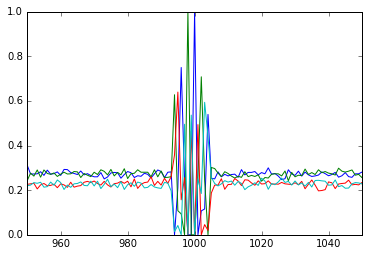

In [72]:
x_ = np.squeeze(np.mean(x,axis=0))
plt.plot(x_)
plt.xlim(1000-50, 1000+50)

(950, 1050)

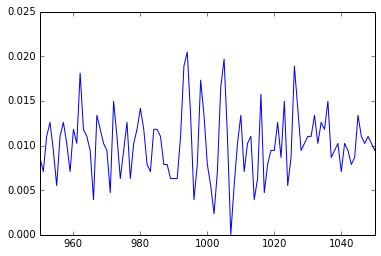

In [69]:
plt.plot(np.mean(y,0))
plt.xlim(1000-50, 1000+50)

In [10]:
flags = tf.app.flags
# flags.DEFINE_boolean('predict', False, 'If true, predicts')
FLAGS = flags.FLAGS
print(flags.FLAGS)
FLAGS.batch_size = 128
FLAGS.EPOCH_SIZE = 500
FLAGS.TEST_SIZE = 20
FLAGS.BATCH_SIZE = 20
FLAGS.lr = 0.02
FLAGS.save_path = "pt_checkpoint/"
# train_images, train_labels = data_utils.permute_data(get_whole_batch(conn, where={"chr":"chr21"}))

In [11]:
xrange = range
def main(_=None, ):
    # Since we are feeding our data as numpy arrays, we need to create
    # placeholders in the graph.
    # These must then be fed using the feed dict.
    xlen = 2001
    xdepth = 4
    image_placeholder = tf.placeholder(tf.float32, [FLAGS.BATCH_SIZE, 1, xlen, xdepth], name="dna")
    labels_placeholder = tf.placeholder(tf.float32, [FLAGS.BATCH_SIZE, xlen], name="atac")

    # Create our model.  The result of softmax_classifier is a namedtuple
    # that has members result.loss and result.softmax.

    result = network(image_placeholder, output_shape = [None,1,xlen, 1])
    loss = result.poisson_regression(labels_placeholder)
    # For tracking accuracy in evaluation, we need to add an evaluation node.
    # We only include this part of the graph when testing, so we need to specify
    # that in the phase.
    # Some ops have different behaviors in test vs train and these take a phase
    # argument.
    #loss = result.l2_regression(labels_placeholder,)

    # Grab the data as numpy arrays.
    test_images, test_labels = data_utils.permute_data(get_whole_batch(conn, where={"chr":"chr22"},binary=False))

    # Create the gradient optimizer and apply it to the graph.
    # pt.apply_optimizer adds regularization losses and sets up a step counter
    # (pt.global_step()) for you.
    optimizer = tf.train.GradientDescentOptimizer(FLAGS.lr)
    train_op = pt.apply_optimizer(optimizer, losses=[loss])

    # We can set a save_path in the runner to automatically checkpoint every so
    # often.  Otherwise at the end of the session, the model will be lost.
    runner = pt.train.Runner(save_path=FLAGS.save_path)
    with tf.Session():
        for epoch in xrange(10):
            # Shuffle the training data.
            train_images, train_labels = data_utils.permute_data(get_whole_batch(conn,
                                                                where={"chr":"chr21"}, binary=False))
            for batch_num, (train_images, train_labels) in enumerate(train_batchloader(FLAGS.EPOCH_SIZE)):
                tr = pt.train.feed_numpy(FLAGS.BATCH_SIZE, train_images, train_labels)
                ts = pt.train.feed_numpy(FLAGS.BATCH_SIZE,  test_images, test_labels)
                runner.train_model(
                  train_op,
                  loss,
                  FLAGS.EPOCH_SIZE // FLAGS.BATCH_SIZE,
                  feed_vars=(image_placeholder, labels_placeholder),
                  feed_data=tr,
                  print_every=10)
                loss_value = runner.evaluate_model(
                  loss,
                  FLAGS.EPOCH_SIZE // FLAGS.BATCH_SIZE,
                  feed_vars=(image_placeholder, labels_placeholder),
                  feed_data=ts)
            print('Loss after %d epoch %g' % (
              epoch + 1, loss_value))


In [18]:
def predict(_=None, ):
    # Since we are feeding our data as numpy arrays, we need to create
    # placeholders in the graph.
    # These must then be fed using the feed dict.
    xlen = 2001
    xdepth = 4
    image_placeholder = tf.placeholder(tf.float32, [FLAGS.BATCH_SIZE, 1, xlen, xdepth], name="dna")
    labels_placeholder = tf.placeholder(tf.float32, [FLAGS.BATCH_SIZE, xlen], name="atac")

    # Create our model.  The result of softmax_classifier is a namedtuple
    # that has members result.loss and result.softmax.

    result = network(image_placeholder, output_shape = [None,1,xlen, 1])
    loss = result.poisson_regression(labels_placeholder)
 
    test_images, test_labels = data_utils.permute_data(get_whole_batch(conn, where={"chr":"chr22"},binary=False))

    runner = pt.train.Runner(save_path=FLAGS.save_path)
    ts = pt.train.feed_numpy(FLAGS.BATCH_SIZE,  test_images, test_labels)
    with tf.Session() as sess:
        runner.load_from_checkpoint(sess)
        for batch_num, (train_images, train_labels) in enumerate(train_batchloader(FLAGS.EPOCH_SIZE)):
            res = runner.evaluate_model(
              result,
              FLAGS.EPOCH_SIZE // FLAGS.BATCH_SIZE,
              feed_vars=(image_placeholder),
              feed_data=ts)

            loss_value = runner.evaluate_model(
              loss,
              FLAGS.EPOCH_SIZE // FLAGS.BATCH_SIZE,
              feed_vars=(image_placeholder),
              feed_data=ts)
            print('Loss after %d epoch %g' % (
              loss_value))


In [15]:
# runner = pt.train.Runner(save_path=FLAGS.save_path)
# runner.load_from_checkpoint?

In [19]:
# main()
predict()

NotFoundError: Tensor name "poisson_regression_2/truediv_average" not found in checkpoint files pt_checkpoint/-1001
	 [[Node: save_4/restore_slice_24 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_4/Const_0, save_4/restore_slice_24/tensor_name, save_4/restore_slice_24/shape_and_slice)]]
Caused by op 'save_4/restore_slice_24', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2815, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-b11244c6ad22>", line 2, in <module>
    predict()
  File "<ipython-input-18-776607df87b2>", line 18, in predict
    runner = pt.train.Runner(save_path=FLAGS.save_path)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/prettytensor/local_trainer.py", line 90, in __init__
    self._create_initializers()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/prettytensor/local_trainer.py", line 126, in _create_initializers
    self._saver = tf.train.Saver(tf.all_variables(), max_to_keep=5)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 845, in __init__
    restore_sequentially=restore_sequentially)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 515, in build
    filename_tensor, vars_to_save, restore_sequentially, reshape)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 271, in _AddRestoreOps
    values = self.restore_op(filename_tensor, vs, preferred_shard)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 186, in restore_op
    preferred_shard=preferred_shard)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/ops/io_ops.py", line 202, in _restore_slice
    preferred_shard, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 358, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/ops/op_def_library.py", line 704, in apply_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2260, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1230, in __init__
    self._traceback = _extract_stack()


In [31]:
np.r_[[int(c) for c in zsh]] - np.r_[0,1]

array([2, 2])